In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from random import random 
from random import sample 
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

matplotlib.rc('font', **{'size'   : 16})

In [3]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

In [4]:
data.columns

Index(['File Name', 'Target ID', 'Race', 'Gender', 'Emotion', 'Age', 'Origin',
       'amazon_age_low', 'amazon_age_high', 'amazon_smile',
       'amazon_smile_confidence', 'amazon_gender', 'amazon_gender_confidence',
       'amazon_emotion', 'clarifai_race', 'clarifai_race_confidence',
       'clarifai_gender', 'clarifai_gender_confidence', 'clarifai_age',
       'clarifai_age_confidence', 'face++_gender', 'face++_age',
       'face++_emotion', 'face++_smile', 'microsoft_gender', 'microsoft_age',
       'microsoft_emotion', 'microsoft_smile', 'amazon_age_average',
       'microsoft_smile_confidence'],
      dtype='object')

In [5]:
cfd = data[data["Origin"] == "CFD"].copy()
nimstim = data[data["Origin"] == "NimStim"].copy()
airbnb = data[data["Origin"] == "AirBnb"].copy()
ai = data[data["Origin"] == "AI"].copy()
datasets = {"CFD": cfd, "NimStim": nimstim, "AirBnb": airbnb, "AI": ai}

# 1. Data Exploration and Visualisation

In [6]:
print("Females", sum(data["Gender"] == 1))
print("Males", sum(data["Gender"] == 2))
print("Asian", sum(data["Race"] == 1)/len(data))
print("Black", sum(data["Race"] == 2)/len(data))
print("Latino", sum(data["Race"] == 3)/len(data))
print("White", sum(data["Race"] == 4)/len(data))
print("Others", (sum(data["Race"] == 5) + sum(data["Race"] == 0))/len(data))

Females 1357
Males 1319
Asian 0.17407545760179305
Black 0.2764288382517744
Latino 0.0788195741501681
White 0.4691819200597684
Others 0.0014942099364960778


In [7]:
for n, em in enumerate(["other", "angry", "calm/neutral", "disgusted", "fearful", "happy", "sad", "surprised"]): 
    print(em, sum(data["Emotion"] == n), sum(data["Emotion"] == n) * 100/len(data.query("Emotion != -1")))

other 4 0.16467682173734047
angry 241 9.921778509674763
calm/neutral 954 39.2754219843557
disgusted 82 3.3758748456154795
fearful 232 9.551255660765747
happy 779 32.070811033347056
sad 86 3.54055166735282
surprised 51 2.099629477151091


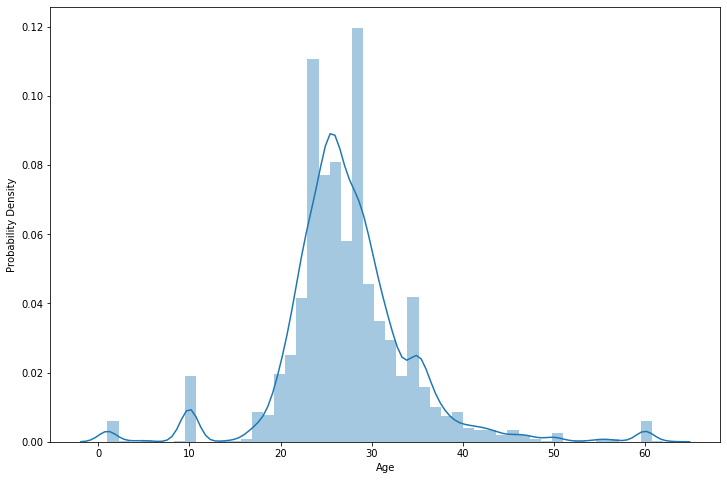

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(data["Age"]);
plt.xlabel("Age")
plt.ylabel("Probability Density")
# Uncomment this part to save the figure as .svg
# plt.savefig('myimage.svg', format='svg', dpi=1200)
plt.show()

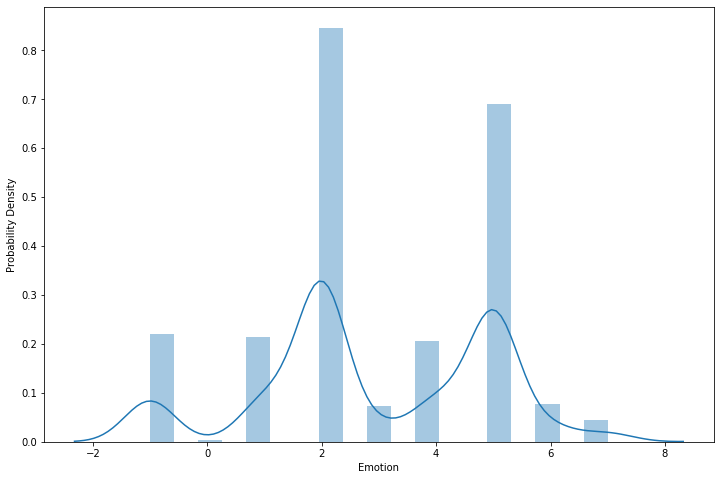

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(data["Emotion"]);
plt.xlabel("Emotion")
plt.ylabel("Probability Density")
plt.show()

In [10]:
def gender_distribution_graph(): 
    # Bar chart adapted from https://stackoverflow.com/questions/48157735/plot-multiple-bars-for-categorical-data
    plt.figure(figsize=(12,7)) 
    mps = []
    fps = [] 
    ind = np.arange(len(datasets.keys()))
    for ds in datasets:
        male_proportion = len(datasets[ds]["Gender"][datasets[ds]["Gender"]==2])/len(datasets[ds])
        female_proportion = len(datasets[ds]["Gender"][datasets[ds]["Gender"]==1])/len(datasets[ds])
        mps.append(male_proportion)
        fps.append(female_proportion)
    plt.bar(ind - 0.2, mps, 0.4, label="Males")
    plt.bar(ind + 0.2, fps, 0.4 ,label="Females")
    plt.xticks(ind, datasets.keys())
    plt.ylabel("Proportion of the population")
    plt.axhline(y=0.5, color='r', label="Balanced population line")
    plt.legend(loc="lower right")
    plt.show() 

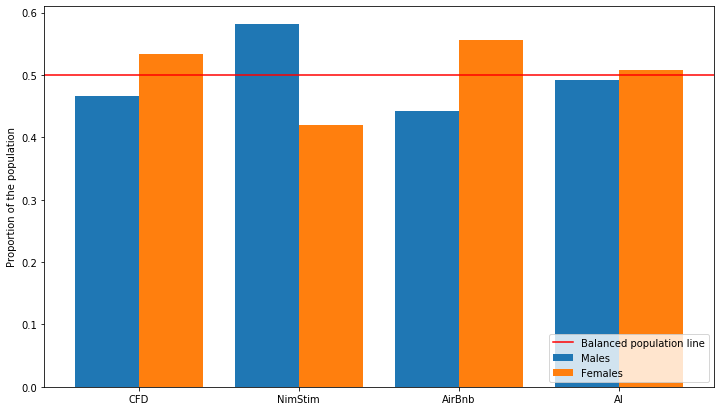

In [11]:
gender_distribution_graph()

Confirms observation that most AirBnb hosts are women. 

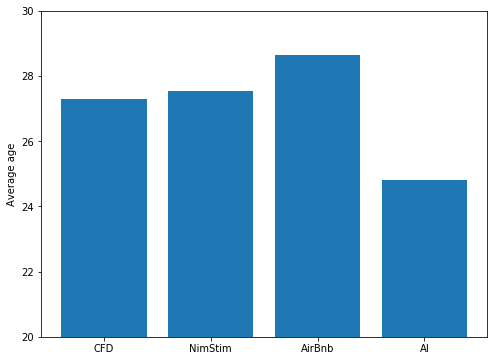

In [12]:
plt.figure(figsize=(8,6)) 
plt.bar(datasets.keys(), [sum(datasets[ds]["Age"])/len(datasets[ds]) for ds in datasets.keys()])
plt.ylabel("Average age")
plt.ylim(20, 30)
plt.show()

AirBnb are hosts - own a property --> makes sense to be older on average. 

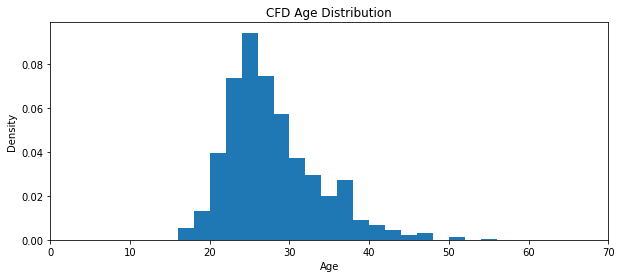

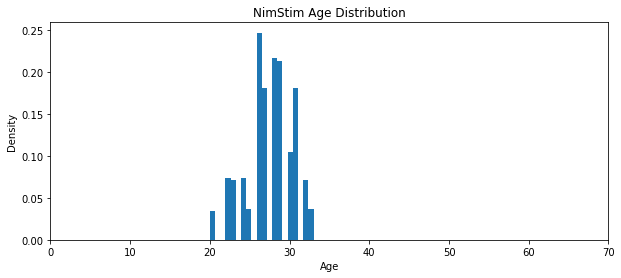

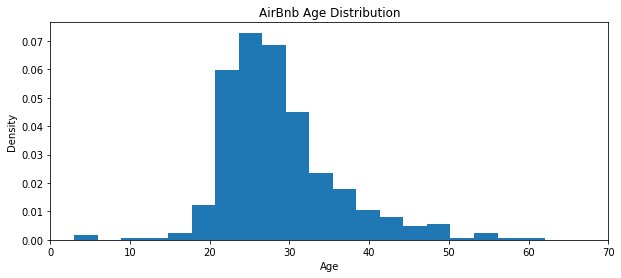

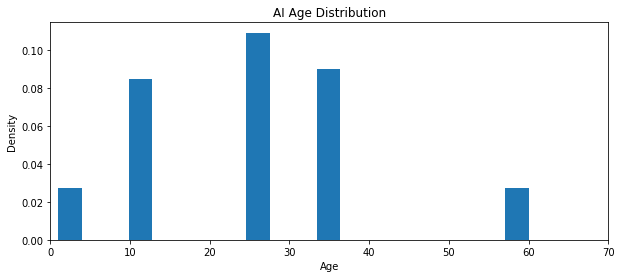

In [13]:
for ds in datasets.keys(): 
    plt.figure(figsize=(10,4)) 
    plt.hist(datasets[ds]["Age"], bins=20, density=True)
    plt.title(ds + " Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.xlim(0, 70)
    plt.show()

In [30]:
races_meaning = {
    1: 'asian',
    2: 'black',
    3: 'latino',
    4: 'white',
    5: 'middle_eastern',
    0: 'other',
}

races_meaning_main = {x: races_meaning[x] for x in range(1,5)}

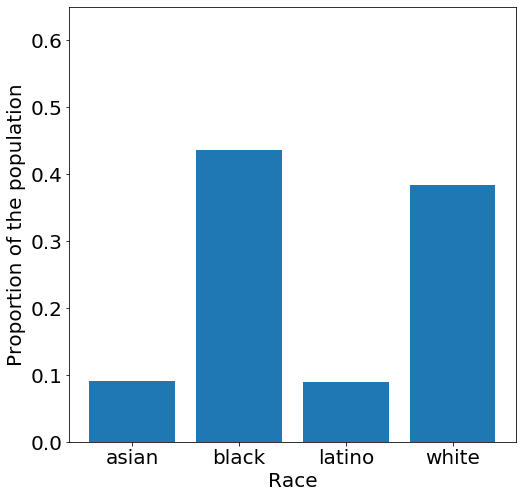

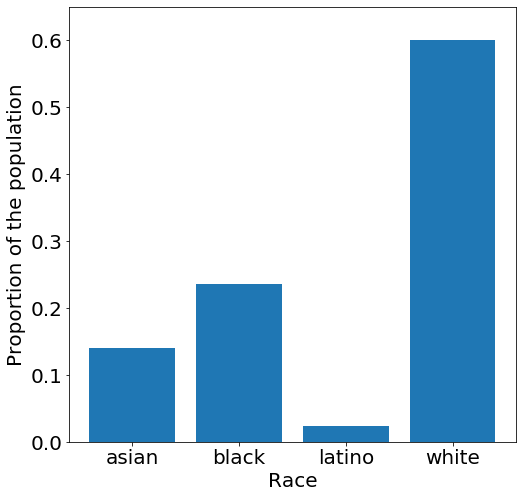

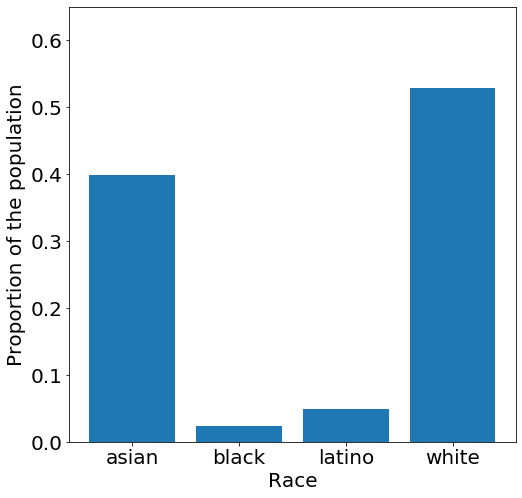

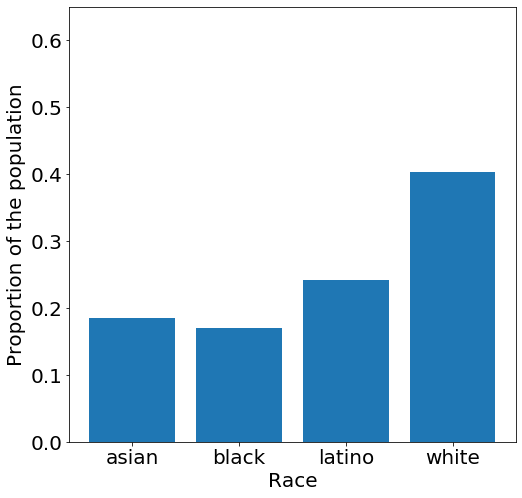

In [39]:
for ds in datasets.keys(): 
    df = datasets[ds].query("Race in [1,2,3,4]")
    plt.figure(figsize=(8,8)) 
    plt.bar(races_meaning_main.values(), [len(df[df["Race"]==race])/len(df) for race in races_meaning_main])
    plt.ylabel("Proportion of the population")
    plt.xlabel("Race")
    plt.ylim(0, 0.65)
    # Uncomment the line below to save the graph locally as a .svg file
    # plt.savefig(str(ds) + '_dist.svg', format='svg', dpi=1200)
    plt.show()

In [148]:
nimstim[["Age", "face++_age"]]

,Age,face++_age
1207,28,31
1208,28,37
1209,28,37
1210,28,32
1211,28,28
...,...,...
1875,29,29
1876,29,32
1877,29,33
1878,29,49


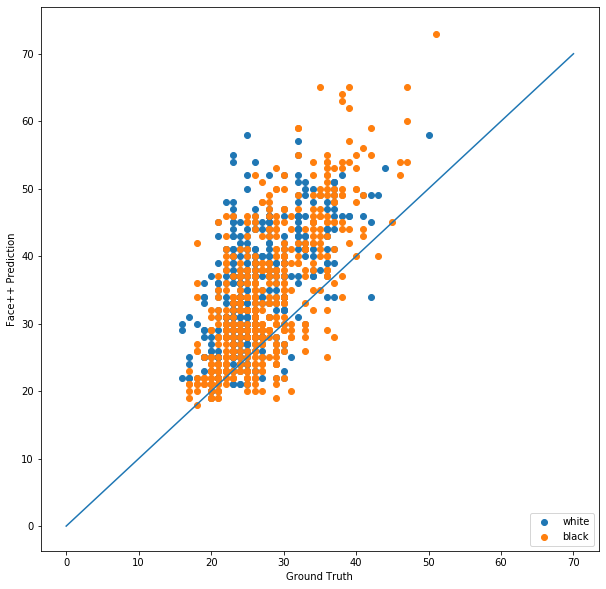

In [149]:
plt.figure(figsize=(10,10)) 

plt.scatter(cfd["Age"][cfd["Race"]==4], cfd["face++_age"][cfd["Race"]==4], label="white")
plt.scatter(cfd["Age"][cfd["Race"]==2], cfd["face++_age"][cfd["Race"]==2], label="black")
plt.ylabel("Face++ Prediction")
plt.xlabel("Ground Truth")
plt.legend(loc="lower right")
plt.plot(np.linspace(0,70,100), np.linspace(0,70,100))
plt.show()

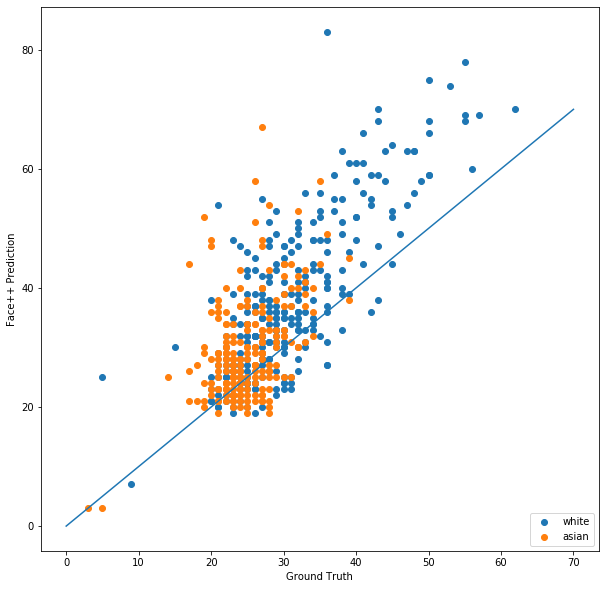

In [150]:
plt.figure(figsize=(10,10)) 

plt.scatter(airbnb["Age"][airbnb["Race"]==4], airbnb["face++_age"][airbnb["Race"]==4], label="white")
plt.scatter(airbnb["Age"][airbnb["Race"]==1], airbnb["face++_age"][airbnb["Race"]==1], label="asian")
plt.ylabel("Face++ Prediction")
plt.xlabel("Ground Truth")
plt.legend(loc="lower right")
plt.plot(np.linspace(0,70,100), np.linspace(0,70,100))


plt.show()

# 2. Linear Regression Analysis

In [151]:
from sklearn.feature_selection import f_regression 

More on linear regression here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

`f_regression` described here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

Should I be taking an absolute value here? 

In [152]:
data.columns

Index(['File Name', 'Target ID', 'Race', 'Gender', 'Emotion', 'Age', 'Origin',
       'amazon_age_low', 'amazon_age_high', 'amazon_smile',
       'amazon_smile_confidence', 'amazon_gender', 'amazon_gender_confidence',
       'amazon_emotion', 'clarifai_race', 'clarifai_race_confidence',
       'clarifai_gender', 'clarifai_gender_confidence', 'clarifai_age',
       'clarifai_age_confidence', 'face++_gender', 'face++_age',
       'face++_emotion', 'face++_smile', 'microsoft_gender', 'microsoft_age',
       'microsoft_emotion', 'microsoft_smile', 'amazon_age_average',
       'microsoft_smile_confidence'],
      dtype='object')

In [153]:
X = data[["Gender"]].copy()
y = abs(data.Gender - data["clarifai_gender"]).copy()

In [154]:
lr = LogisticRegression()

In [155]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [156]:
lr.score(X, y)

0.8752334703025775

In [157]:
lr.intercept_

array([0.59171698])

In [158]:
lr.coef_

array([[-1.91741963]])

In [159]:
def sigmoid(x): 
    return 1/(1 + np.exp(-x))

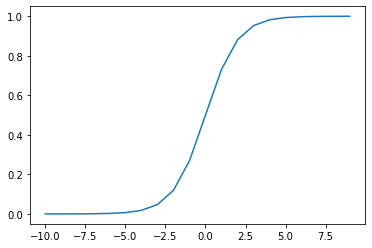

In [160]:
plt.plot([x for x in range(-10,10)], [sigmoid(x) for x in range(-10,10)])

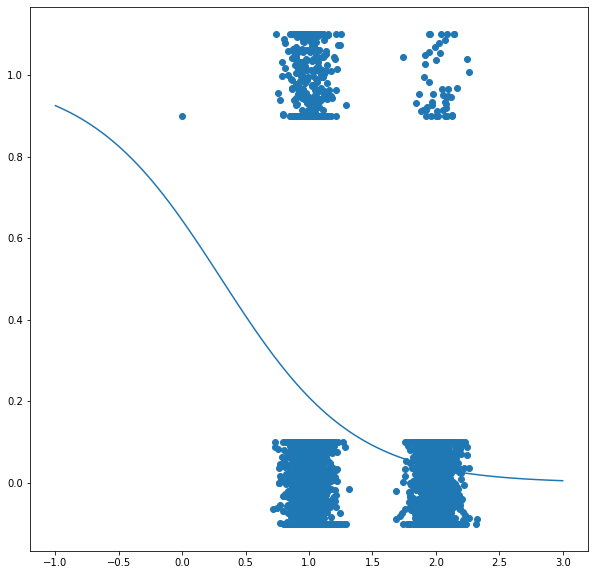

In [161]:
plt.figure(figsize=(10,10)) 
plt.scatter([np.random.normal(0,0.1) + x for x in X["Gender"]], 
            [np.clip(np.random.normal(0,0.1), -0.1, 0.1) + x for x in y])
plt.plot([x for x in np.linspace(-1, 3, 100)], 
         [sigmoid(lr.intercept_[0] + lr.coef_[0][0] * x) for x in np.linspace(-1,3,100)]
        )
plt.show()

In [162]:
f_regression(X, y)

(array([203.55973998]), array([1.44558721e-44]))

## Misclassification Analysis 

In [163]:
len(data[abs(data.clarifai_gender - data.Gender)==1])

335

In [164]:
def get_binary_misclassifications(f1, f2): 
    return data[abs(data[f1] - data[f2])==1]

In [165]:
# Starting with gender misclassification
print("Total misclassifications of gender: ")
print("Amazon: ", len(get_binary_misclassifications("amazon_gender", "Gender")))
print("Microsoft: ", len(get_binary_misclassifications("microsoft_gender", "Gender")))
print("Clarifai: ", len(get_binary_misclassifications("clarifai_gender", "Gender")))
print("Face++: ", len(get_binary_misclassifications("face++_gender", "Gender")))

Total misclassifications of gender: 
Amazon:  100
Microsoft:  48
Clarifai:  335
Face++:  169


In [166]:
clarifai_gender_error = abs(data.Gender - data.clarifai_gender)
clarifai_misclass = data[abs(data.Gender - data.clarifai_gender) == 1]

In [167]:
data["Gender"]

0       2
1       2
2       2
3       2
4       2
       ..
2672    1
2673    1
2674    1
2675    1
2676    2
Name: Gender, Length: 2677, dtype: int64

In [168]:
races_meaning

{1: 'asian',
 2: 'black',
 3: 'latino',
 4: 'white',
 5: 'middle_eastern',
 0: 'other'}

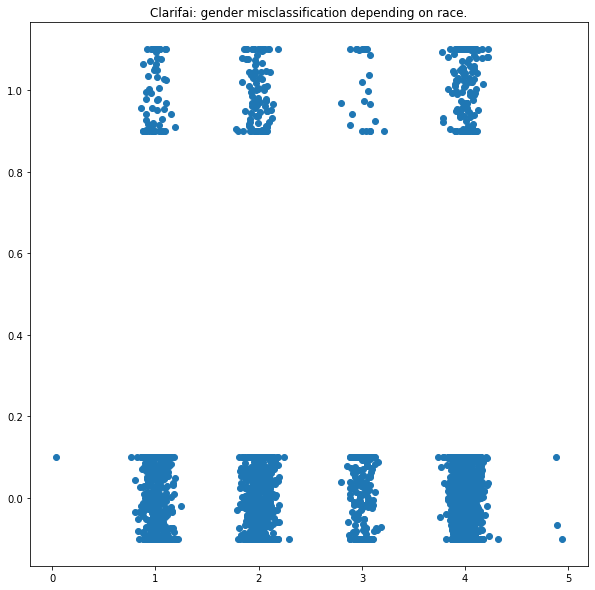

In [169]:
# Trying "jittered" scatter plots 
plt.figure(figsize=(10,10)) 
plt.scatter([x + np.random.normal(0, 0.08) for x in data["Race"]], 
            [x + np.clip(np.random.normal(0, 0.12), -0.1, 0.1) for x in clarifai_gender_error])
plt.title("Clarifai: gender misclassification depending on race.")
plt.show()

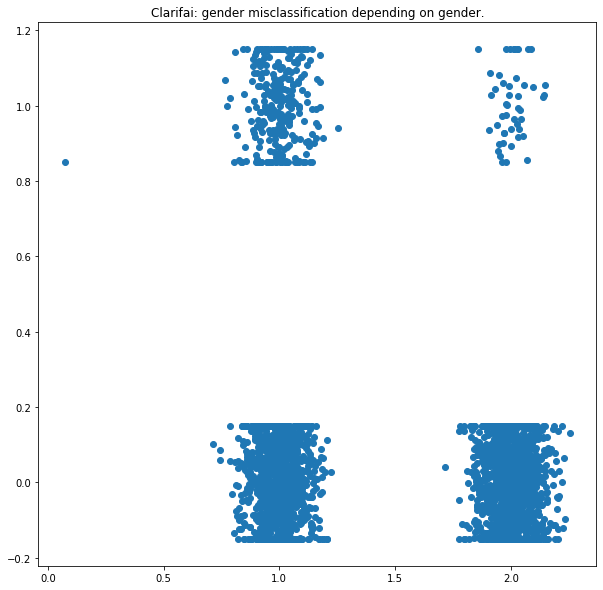

In [170]:
plt.figure(figsize=(10,10)) 
plt.scatter([x + np.random.normal(0, 0.08) for x in data["Gender"]], 
            [x + np.clip(np.random.normal(0, 0.12),-0.15, 0.15) for x in clarifai_gender_error])
plt.title("Clarifai: gender misclassification depending on gender.")
plt.show()

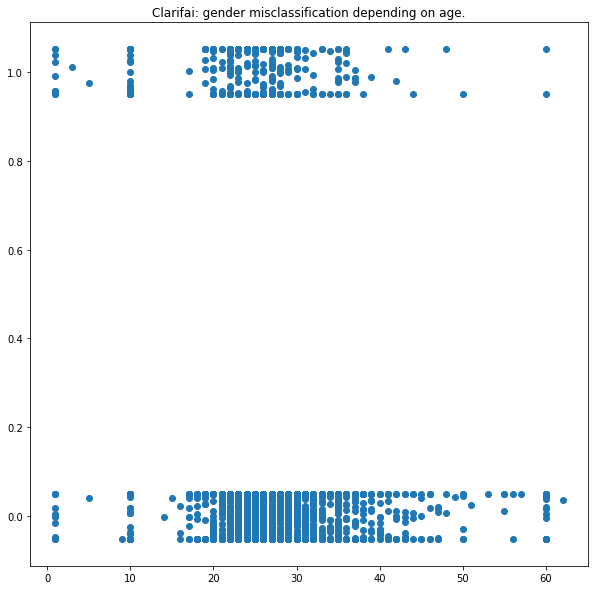

In [171]:
plt.figure(figsize=(10,10)) 
plt.scatter(data["Age"], 
            [x + np.clip(np.random.normal(0, 0.10), -0.05, 0.05) for x in clarifai_gender_error])
plt.title("Clarifai: gender misclassification depending on age.")
plt.show()

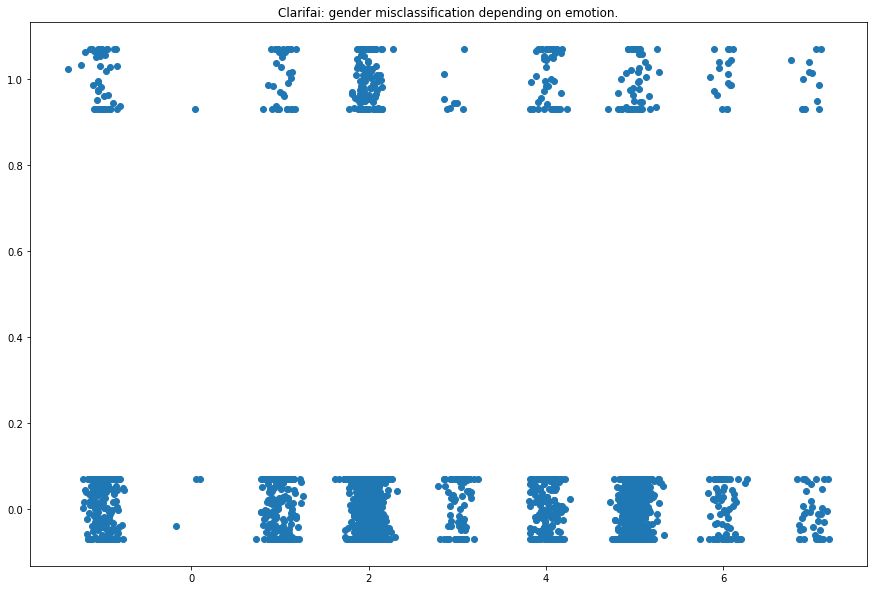

In [172]:
plt.figure(figsize=(15,10)) 
plt.scatter([x + np.random.normal(0, 0.10) for x in data["Emotion"]], 
            [x + np.clip(np.random.normal(0, 0.10),-0.07, 0.07) for x in clarifai_gender_error])
plt.title("Clarifai: gender misclassification depending on emotion.")
plt.show()

In [173]:
print("Clarifai misclassified the gender of a total of", sum(clarifai_misclass["Gender"] == 2), "men")
print("Total men in the population:", sum(data["Gender"] == 2))
print("Percentage of misclassified men:", sum(clarifai_misclass["Gender"] == 2)/sum(data["Gender"] == 2))
print("=" * 50)
print("Clarifai misclassified the gender of a total of", sum(clarifai_misclass["Gender"] == 1), "women")
print("Total women in the population:", sum(data["Gender"] == 1))
print("Percentage of misclassified women:", sum(clarifai_misclass["Gender"] == 1)/sum(data["Gender"] == 1))

Clarifai misclassified the gender of a total of 48 men
Total men in the population: 1319
Percentage of misclassified men: 0.03639120545868082
Clarifai misclassified the gender of a total of 286 women
Total women in the population: 1357
Percentage of misclassified women: 0.210759027266028


In [174]:
races_meaning

{1: 'asian',
 2: 'black',
 3: 'latino',
 4: 'white',
 5: 'middle_eastern',
 0: 'other'}

In [175]:
set(data["Race"])

{0, 1, 2, 3, 4, 5}

In [176]:
for race in races_meaning: 
    print("Misclassified", races_meaning[race], ":", sum(clarifai_misclass["Race"] == race))
    print("Total in the population:", sum(data["Race"] == race))
    print("Misclassification rate:", sum(clarifai_misclass["Race"] == race)/sum(data["Race"] == race))
    print("=" * 50)

Misclassified asian : 62
Total in the population: 466
Misclassification rate: 0.13304721030042918
Misclassified black : 106
Total in the population: 740
Misclassification rate: 0.14324324324324325
Misclassified latino : 23
Total in the population: 211
Misclassification rate: 0.10900473933649289
Misclassified white : 144
Total in the population: 1256
Misclassification rate: 0.11464968152866242
Misclassified middle_eastern : 0
Total in the population: 3
Misclassification rate: 0.0
Misclassified other : 0
Total in the population: 1
Misclassification rate: 0.0


## Uncertainty Analysis 

In [177]:
clarifai_gender_error==True

0       False
1       False
2       False
3       False
4       False
        ...  
2672    False
2673    False
2674    False
2675    False
2676    False
Length: 2677, dtype: bool

In [178]:
clarifai_gender_error

0       0
1       0
2       0
3       0
4       0
       ..
2672    0
2673    0
2674    0
2675    0
2676    0
Length: 2677, dtype: int64

In [179]:
data_male = data["Gender"]==2
data_female = data["Gender"]==1

In [180]:
clarifai_gender_error[data_male]

0       0
1       0
2       0
3       0
4       0
       ..
2661    0
2665    0
2666    0
2670    0
2676    0
Length: 1319, dtype: int64

In [181]:
clarifai_gender_error[data_female]

6       0
13      0
28      0
60      0
66      0
       ..
2671    0
2672    0
2673    0
2674    0
2675    0
Length: 1357, dtype: int64

In [182]:
np.mean(clarifai_gender_error)

0.1251400821815465

In [183]:
np.mean(clarifai_gender_error[data_female])

0.210759027266028

In [184]:
np.mean(clarifai_gender_error[data_male])

0.03639120545868082

In [185]:
np.var(clarifai_gender_error)

0.10948004201314059

In [186]:
np.var(clarifai_gender_error[data_female])

0.16633965969191059

In [187]:
np.var(clarifai_gender_error[data_male])

0.03506688562394502

For the "population" distribution (i.e. all errors) we have: 

In [188]:
print("Mean:", np.mean(clarifai_gender_error))
print("Variance:", np.var(clarifai_gender_error))

Mean: 0.1251400821815465
Variance: 0.10948004201314059


Now we will assume that: $P(\text{misclassification}|\text{gender}) = P(\text{misclassification})$ i.e. that misclassification is independent of the subject's gender. Then, the mean of $M_1 + ... + M_n$ where $M_i$ is the value of misclassification (true or false) should follow a normal distribution with a mean of $\mu_{M}$ - the global mean, and a variation of $\sigma_{M}^2/N$ where N is the number of samples (number of women in the data). 

In [189]:
female_N = len(clarifai_gender_error[data_female])
female_mean = sum(clarifai_gender_error[data_female])/female_N

In [190]:
np.random.normal(0,1)

0.6240346345611055

In [191]:
x = np.linspace(-3,3,900)

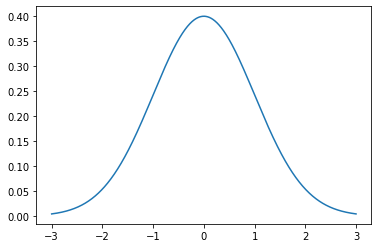

In [192]:
plt.plot(x, norm.pdf(x)) 
plt.show() 

In [193]:
z_value = (female_mean - np.mean(clarifai_gender_error))/np.sqrt(np.var(clarifai_gender_error)/female_N)
print(z_value)

9.532181843393365


In [194]:
def test_independence(sample, population): 
    """Return z-value of the statistical test"""
    return (np.mean(sample) - np.mean(population))/np.sqrt(np.var(population)/len(sample))

In [195]:
test_independence(clarifai_gender_error[data_female], clarifai_gender_error)

9.532181843393365

In [196]:
rv = [np.round(random()) for x in range(2600)]

In [197]:
# Works better for smaller subsets

res = []
for x in range(1000): 
    z = test_independence(sample(rv, 100), rv)
    if abs(z) >= 1.96: 
        res.append(z)
print("Hypothesis holds in :", (1 - len(res)/1000) * 100, "% of the cases")

Hypothesis holds in : 95.6 % of the cases


In [198]:
test_independence(clarifai_gender_error[data["Gender"]==1], clarifai_gender_error)

9.532181843393365

In [199]:
test_independence(clarifai_gender_error[data["Race"]==4], clarifai_gender_error)

-1.1236198870919378

## Logistic Regression with Age

In [200]:
age_lr = LogisticRegression() 

In [201]:
age_lr.fit(data[["Age"]], clarifai_gender_error)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

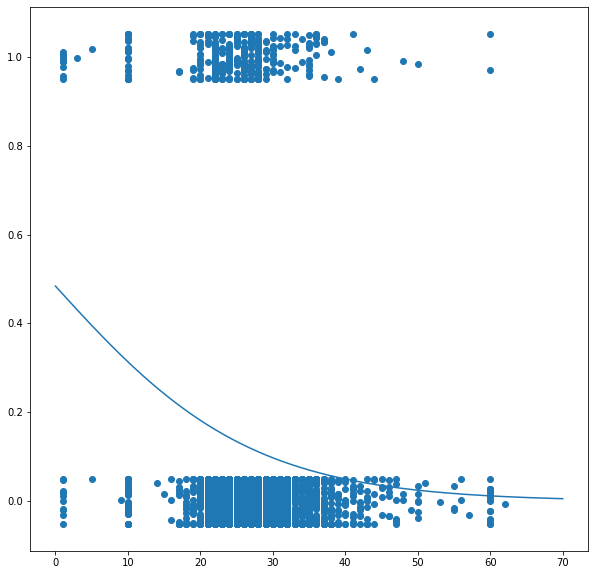

In [202]:
X = data[["Age"]].copy()

plt.figure(figsize=(10,10)) 
plt.scatter([x for x in X["Age"]], [np.clip(np.random.normal(0,0.04), -0.05, 0.05) + x for x in y])
plt.plot([x for x in np.linspace(0, 70, 1000)], 
         [sigmoid(age_lr.intercept_[0] + age_lr.coef_[0][0] * x) for x in np.linspace(0,70,1000)]
        )
plt.show()

In [203]:
age_lr.coef_

array([[-0.07186911]])

In [239]:
random_vector = pd.DataFrame(np.random.randint(2, size=len(data)).reshape(-1, 1), columns=["random vector"])
ones = pd.DataFrame(np.ones(len(data)).reshape(-1, 1), columns=["ones"])

In [240]:
ones

,ones
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
2672,1.0
2673,1.0
2674,1.0
2675,1.0


In [241]:
random_data = data.join(random_vector)
random_data = random_data.join(ones)
random_data

,File Name,Target ID,Race,Gender,Emotion,Age,Origin,amazon_age_low,amazon_age_high,amazon_smile,...,face++_emotion,face++_smile,microsoft_gender,microsoft_age,microsoft_emotion,microsoft_smile,amazon_age_average,microsoft_smile_confidence,random vector,ones
0,CFD-WM-026-019-A.jpg,WM-026,4,2,1,25,CFD,22,34,0,...,2,0,2,22.0,2,0,28.0,0.001,0,1.0
1,CFD-WM-026-006-HO.jpg,WM-026,4,2,5,25,CFD,22,34,1,...,5,1,2,21.0,5,1,28.0,1.000,1,1.0
2,CFD-WM-026-004-HC.jpg,WM-026,4,2,5,25,CFD,22,34,0,...,2,0,2,23.0,5,1,28.0,0.774,1,1.0
3,CFD-WM-026-001-N.jpg,WM-026,4,2,2,25,CFD,22,34,0,...,2,0,2,21.0,2,0,28.0,0.000,0,1.0
4,CFD-WM-026-013-F.jpg,WM-026,4,2,4,25,CFD,22,34,0,...,1,0,2,23.0,7,0,28.0,0.000,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,5dd09cb3def8b400084dc569_female_white_young-ad...,5dd09cb3def8b400084dc569,4,1,-1,25,AI,18,30,1,...,5,1,1,24.0,5,1,24.0,1.000,0,1.0
2673,5dd09cb3def8b400084dc56a_female_white_young-ad...,5dd09cb3def8b400084dc56a,4,1,-1,25,AI,19,31,1,...,5,1,1,24.0,5,1,25.0,1.000,0,1.0
2674,5dd09cb3def8b400084dc56b_female_white_adult.jpeg,5dd09cb3def8b400084dc56b,4,1,-1,35,AI,26,40,1,...,5,1,1,31.0,5,1,33.0,1.000,1,1.0
2675,5dd09cb4def8b400084dc56c_female_white_young-ad...,5dd09cb4def8b400084dc56c,4,1,-1,25,AI,20,32,1,...,5,1,1,30.0,5,1,26.0,1.000,1,1.0


In [251]:
age_logit = sm.Logit(clarifai_gender_error, data[["Age", "Gender", "Race"]])
print(age_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.337163
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2677
Model:                          Logit   Df Residuals:                     2674
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1058
Time:                        21:28:05   Log-Likelihood:                -902.58
converged:                       True   LL-Null:                       -1009.3
Covariance Type:            nonrobust   LLR p-value:                 4.320e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0231      0.006     -3.616      0.000      -0.036      -0.011
Gender        -1.3742      0.

In [252]:
age_logit = sm.Logit(clarifai_gender_error, random_data[["Age", "Gender", "Race", "random vector", "ones"]])
print(age_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.326186
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2677
Model:                          Logit   Df Residuals:                     2672
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1349
Time:                        21:28:37   Log-Likelihood:                -873.20
converged:                       True   LL-Null:                       -1009.3
Covariance Type:            nonrobust   LLR p-value:                 1.025e-57
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.0750      0.010     -7.649      0.000      -0.094      -0.056
Gender           -1.

## Statistical Correlation Tests

### Phi Coefficient
Following the definition and notation specified here: https://en.wikipedia.org/wiki/Phi_coefficient

In [788]:
male_mask = data["Gender"] == 2
female_mask = data["Gender"] == 1

misclass_mask = clarifai_gender_error == 1
class_mask = clarifai_gender_error == 0

In [789]:
n11 = len(data[male_mask & misclass_mask])
n10 = len(data[male_mask & class_mask])
n01 = len(data[female_mask & misclass_mask]) 
n00 = len(data[female_mask & class_mask])

In [790]:
n11 + n10 + n01 + n00 

2676

In [791]:
n = n11 + n10 + n01 + n00 
n1_ = n11 + n10 
n_1 = n01 + n11
n0_ = n01 + n00 
n_0 = n00 + n10 

In [792]:
phi = (n*n11 - n1_ * n_1)/np.sqrt(n1_ * n_1 * (n - n1_) * (n - n_1))

In [793]:
phi

-0.26376185302897437

In [548]:
phi = (n11 * n00 - n10 * n01) / np.sqrt(n_0 * n_1 * n0_ * n1_)

In [549]:
pd.DataFrame([[n11, n10], 
              [n01, n00]])

,0,1
0,48,1271
1,286,1071


In [526]:
n01

286

### Spearman Correlation Test

In [657]:
spearmanr(data["Gender"], clarifai_gender_error)

SpearmanrResult(correlation=-0.2651955419918812, pvalue=2.530303268629991e-44)

In [658]:
data["Race"]==4

0       True
1       True
2       True
3       True
4       True
        ... 
2672    True
2673    True
2674    True
2675    True
2676    True
Name: Race, Length: 2677, dtype: bool

In [673]:
binary_race = data["Race"].copy()

In [674]:
white_mask = binary_race==4
black_mask = binary_race==2
asian_mask = binary_race==1
non_white_mask = binary_race!=4
non_black_mask = binary_race!=2

In [675]:
binary_race[white_mask] = 0

In [676]:
binary_race[non_white_mask] = 1

In [677]:
# No significant correlation with all races
spearmanr(data["Race"], clarifai_gender_error)

SpearmanrResult(correlation=-0.03188610155157916, pvalue=0.09906013264320142)

In [678]:
# Splitting races into white and non-white does not yield correlation either 
spearmanr(binary_race, clarifai_gender_error)

SpearmanrResult(correlation=0.029807282130856653, pvalue=0.12311172121833436)

In [679]:
# Only leaving black and whites
binary_race = data.Race[white_mask | black_mask].copy()
binary_race[white_mask] = 0
binary_race[black_mask] = 1

In [680]:
spearmanr(binary_race, clarifai_gender_error[white_mask | black_mask])

SpearmanrResult(correlation=0.04172408404379537, pvalue=0.062358965043838185)

In [682]:
binary_race = data["Race"].copy()

In [683]:
binary_race[black_mask] = 1
binary_race[non_black_mask] = 0

In [685]:
spearmanr(binary_race, clarifai_gender_error)

SpearmanrResult(correlation=0.033817226561568145, pvalue=0.08022579867589884)

In [681]:
spearmanr(data["Age"], clarifai_gender_error)

SpearmanrResult(correlation=-0.14556525835746606, pvalue=3.780415101761311e-14)

### Chi-Square Test

In [721]:
obs = np.array([[10, 10, 20], [20, 20, 20]])

In [735]:
# Chi-Square statistic for gender
chi2_contingency(pd.DataFrame([[n11, n10], 
              [n01, n00]]))

(184.57731915238867,
 4.853705628867457e-42,
 1,
 array([[ 164.62855007, 1154.37144993],
        [ 169.37144993, 1187.62855007]]))

In [64]:
apis = ['Clarifai', 'Microsoft', 'Amazon', 'Face++']
age_groups = ["[0,10)", "[10,20)", "[20,30)", "[30,45)", "45+"]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=age_groups,
    y=[50, 15.51, 13.43, 7.31, 5.40],
    name='Clarifai',
    marker_color='green'
))
fig.add_trace(go.Bar(
    x=age_groups,
    y=[25.0, 1.72, 0.36, 0.14, 0],
    name='Microsoft',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=age_groups,
    y=[75, 10.34, 2.59, 1.19, 0],
    name='Amazon',
    marker_color='orange'
))
fig.add_trace(go.Bar(
    x=age_groups,
    y=[50, 15.51, 6.14, 2.83, 2.70],
    name='Face++',
    marker_color='black'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(
    xaxis_title="Age Group",
    yaxis_title="Misclassification Rate (%)",
    font=dict(
        size=16,
    )
)
fig.show()